In [188]:
import os
current_path = os.getcwd()
import sys
sys.path.append(current_path)
sys.path.append('./../../.')
import numpy as np
import math
from itertools import repeat
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import myInput
import post_processing

In [2]:
## Get the id data

In [3]:

data_folder="/blue/michael.tonks/lin.yang/VECTOR_data/experimental_data/"
data_name_t0 = "s1400poly1_t0_optimized.dream3d"
data_name_t1 = "s1400poly1_t1_fiftytwoslices_optimized.dream3d"

In [95]:
## Get microstructure data

# t0
f = h5py.File(data_folder+data_name_t0, 'r')
simulation = f['DataContainers']['ImageDataContainer']
simulation_id = simulation['CellData']['FeatureIds']
microstructure_t0 = simulation_id[:,:,:,0]
euler_angles_t0 = simulation['CellFeatureData']['AvgQuats']
centers_t0 = simulation['CellFeatureData']['Centroids']
# t1
f = h5py.File(data_folder+data_name_t1, 'r')
simulation = f['DataContainers']['ImageDataContainer']
simulation_id = simulation['CellData']['FeatureIds']
microstructure_t1 = simulation_id[:,:,:,0]
euler_angles_t1 = simulation['CellFeatureData']['AvgQuats']
centers_t1 = simulation['CellFeatureData']['Centroids']

print(microstructure_t0.shape)
print(microstructure_t1.shape)

(50, 500, 500)
(52, 500, 500)


In [325]:
microstructure_t0[37,220,50] # z, y, x

795

In [241]:

correponding_grain_id_for_t1 = np.zeros(len(euler_angles_t1))
correponding_qua_diff_for_t1 = np.zeros(len(euler_angles_t1))
correponding_loc_diff_for_t1 = np.zeros(len(euler_angles_t1))
counted_ids = set()
for ea_i in tqdm(range(1,len(euler_angles_t1))):
    euler_angle = euler_angles_t1[ea_i]
    center = centers_t1[ea_i]
    tmp_correponding_grain_id_for_t1 = []
    tmp_correponding_loc_diff_for_t1 = []
    tmp_correponding_qua_diff_for_t1 = []
    for ea_j in range(1,len(euler_angles_t0)):
        if ea_j in counted_ids: continue
        
        euler_angle_refer = euler_angles_t0[ea_j]
        center_refer = centers_t0[ea_j]
        
        center_diff = center - center_refer
        quat_diff = 1-abs(euler_angle.dot(euler_angle_refer))
        if np.linalg.norm(center_diff) < 50:
            tmp_correponding_grain_id_for_t1.append(ea_j)
            tmp_correponding_qua_diff_for_t1.append(quat_diff)
            tmp_correponding_loc_diff_for_t1.append(np.linalg.norm(center_diff))
        
        # if quat_diff < 0.005:
        #     center_diff = center - center_refer
        #     tmp_correponding_grain_id_for_t1.append(ea_j)
        #     tmp_correponding_qua_diff_for_t1.append(quat_diff)
        #     tmp_correponding_loc_diff_for_t1.append(np.linalg.norm(center_diff))
    tmp_correponding_grain_id_for_t1 = np.array(tmp_correponding_grain_id_for_t1)
    tmp_correponding_qua_diff_for_t1 = np.array(tmp_correponding_qua_diff_for_t1)
    tmp_correponding_loc_diff_for_t1 = np.array(tmp_correponding_loc_diff_for_t1)
    # print(len(tmp_correponding_grain_id_for_t1))
    if len(tmp_correponding_grain_id_for_t1)>=1:
        correponding_grain_id_for_t1[ea_i] = tmp_correponding_grain_id_for_t1[np.argmin(tmp_correponding_qua_diff_for_t1)]
        correponding_qua_diff_for_t1[ea_i] = tmp_correponding_qua_diff_for_t1[np.argmin(tmp_correponding_qua_diff_for_t1)]
        correponding_loc_diff_for_t1[ea_i] = tmp_correponding_loc_diff_for_t1[np.argmin(tmp_correponding_qua_diff_for_t1)]
    else:
        print(f"There is a issue! for {ea_i} in i1")
    counted_ids.add(correponding_grain_id_for_t1[ea_i])
    
# loc_limit = 30
# correponding_grain_id_for_t1[correponding_loc_diff_for_t1>30] = 0
# correponding_qua_diff_for_t1[correponding_loc_diff_for_t1>30] = 0

100%|██████████| 3859/3859 [04:26<00:00, 14.49it/s]


In [279]:

# get t1 ids for t0 grains
correponding_grain_id_for_t0 = np.zeros(len(euler_angles_t0))
for i in range(len(correponding_grain_id_for_t1)):
    if int(correponding_grain_id_for_t1[i]) == 0: continue
    correponding_grain_id_for_t0[int(correponding_grain_id_for_t1[i])] = i

# Get corresponding ids for t1 and t0 from Vivek files
correponding_grain_id_for_t0_vivek = np.zeros(len(euler_angles_t0))
correponding_grain_id_for_t1_vivek = np.zeros(len(euler_angles_t1))
vivek_file = np.loadtxt("./data/sgl_1_09222021.txt")
correponding_grain_id_for_t0_vivek[1:] = vivek_file
for i in range(len(correponding_grain_id_for_t0_vivek)):
    if int(correponding_grain_id_for_t0_vivek[i]) == 0: continue
    correponding_grain_id_for_t1_vivek[int(correponding_grain_id_for_t0_vivek[i])] = i



In [320]:
correponding_grain_id_for_t1_vivek[1]

795.0

In [288]:
# update the microstructure based on valid grains

microstructure_t0_copy = microstructure_t0.copy()
for i in tqdm(range(len(correponding_grain_id_for_t0_vivek))):
    microstructure_t0_copy[microstructure_t0 == i] = correponding_grain_id_for_t0_vivek[i]

100%|██████████| 5464/5464 [00:33<00:00, 163.63it/s]


In [393]:
# compare center

center_diff_ave = np.zeros(3)
valid_grains = len(correponding_grain_id_for_t1_vivek[correponding_grain_id_for_t1_vivek != 0])
for i in range(1,len(centers_t1)):
    if correponding_grain_id_for_t1_vivek[i] == 0: continue
    center_at_t1 = centers_t1[i]
    corresponding_id = int(correponding_grain_id_for_t1_vivek[i])
    center_at_t0 = centers_t0[corresponding_id]
    center_diff_ave += center_at_t1 - center_at_t0
center_diff_ave = center_diff_ave/valid_grains


print(f"Total valid grains is {valid_grains}, The total mismatch is {center_diff_ave}")

real_center_diff_ave = np.array([center_diff_ave[2],center_diff_ave[0],center_diff_ave[1]])/2

# change microstructure
microstructure_current = np.zeros((60,600,600))
microstructure_next = np.zeros((60,600,600))
# microstructure_current[3:,2:,6:] = microstructure_t0_copy
microstructure_current[0:50,2:502,6:506] = microstructure_t0_copy
microstructure_next[0:52,0:500,0:500] = microstructure_t1

Total valid grains is 3196, The total mismatch is [11.81651876  4.59965441  5.51607943]


In [394]:
# calculate curvature
GB_infomation_dict_list = []
for current_microstructure in tqdm([microstructure_t0_copy, microstructure_t1]):
    size_x,size_y,size_z = current_microstructure.shape
    curvature_matrix = post_processing.IO_curvature(current_microstructure)
    GB_infomation_dict = dict()
    for index, result in np.ndenumerate(current_microstructure):
        i,j,k = index
        ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
        if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
             ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
             ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            central_site = int(current_microstructure[i,j,k])
            neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            neighboring_sites_list_unque = list(neighboring_sites_set)
            # remove the TJs and QJs
            if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
            if central_site == 0 or neighboring_sites_list_unque[0] == 0: continue # remove edge GBs
            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
            if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
            else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
            if pair_id in GB_infomation_dict:
                GB_infomation_dict[pair_id][5] += 1 # GB area
                GB_infomation_dict[pair_id][0] += 1 # GB area
            else:
                GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                GB_infomation_dict[pair_id] = GB_infomation
            # calculate or extract curvature
            if pair_id not in curvature_matrix: continue
            GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[pair_id][3]])
    # get the correct location for each GB
    small_GB_list = []
    for key in GB_infomation_dict: 
        if GB_infomation_dict[key][0] == 0: 
            small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
    for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
    for key in GB_infomation_dict: 
        GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
    print(f"Current GBs len: {len(GB_infomation_dict)}")
    # # save information
    # np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
    GB_infomation_dict_list.append(GB_infomation_dict)



 50%|█████     | 1/2 [04:24<04:24, 264.60s/it]

Current GBs len: 16803


100%|██████████| 2/2 [09:06<00:00, 273.22s/it]

Current GBs len: 22140


In [395]:
from numba import njit, prange
import multiprocessing as mp

@njit(parallel=True)
def compute_dV(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
    growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
    growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
    return np.sum(growth_direction1) - np.sum(growth_direction2)

def compute_necessary_info(key,time_interval,
                           GB_infomation_dict_list_one_step_one_key,
                           npy_file_aniso_current,
                           npy_file_aniso_next):


    # Calculate dV and velocity
    dV = compute_dV(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
    velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
    # keep curvature
    current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]

    result = {
        "key": key,
        "velocity": velocity,
        "current_curvature_value": current_curvature_value,
        "is_anti_curvature": current_curvature_value * velocity < -0.0001
    }

    return result

time_interval = 1
# store all GB points, include curvature and anti-curvature(include randomness points)
GB_list_velocity_list = []
GB_list_curvature_list = []
# store anti-curvature GBs in dictionary
GB_id_focus = dict()

# remove disappeared GBs
print(f"key num start with {len(GB_infomation_dict_list[0])}")
tmp_GB_infomation_dict_for_mp = {}
for key in GB_infomation_dict_list[1]:
    if GB_infomation_dict_list[0].get(key) is None: continue
    tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[0][key]
print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
# run key
for key in tqdm(tmp_GB_infomation_dict_for_mp):
    result = compute_necessary_info(key,time_interval,tmp_GB_infomation_dict_for_mp[key],microstructure_current[0],microstructure_next[1])

    # Store these results remove ways-area,lowCurvature
    GB_list_velocity_list.append(result["velocity"])
    GB_list_curvature_list.append(result["current_curvature_value"])

    # keep anti-curvature GB info
    if result["is_anti_curvature"]: 
        if key in GB_id_focus: 
            GB_id_focus[key] += 1
        else: 
            GB_id_focus[key] = 1




key num start with 16803
key num end with 13850


100%|██████████| 13850/13850 [00:05<00:00, 2595.87it/s]


In [396]:
time_interval = 1
GB_antic_list_velocity_AllList = []
GB_antic_list_curvature_AllList = []
GB_antic_list_anticNum_AllList = []
GB_antic_list_velocity_list = []
GB_antic_list_curvature_list = []
GB_antic_list_anticNum_list = []

for key in GB_id_focus:

    result = compute_necessary_info(key,time_interval,tmp_GB_infomation_dict_for_mp[key],microstructure_current[0],microstructure_next[1])
    velocity = result["velocity"]
    current_curvature_value = result["current_curvature_value"]

    # change the sign of the velocity by curvature
    if current_curvature_value < 0: 
        GB_antic_list_velocity_list.append(-velocity)
        GB_antic_list_curvature_list.append(-current_curvature_value)
        GB_antic_list_velocity_AllList.append(-velocity)
        GB_antic_list_curvature_AllList.append(-current_curvature_value)
    else: 
        GB_antic_list_velocity_list.append(velocity)
        GB_antic_list_curvature_list.append(current_curvature_value)
        GB_antic_list_velocity_AllList.append(velocity)
        GB_antic_list_curvature_AllList.append(current_curvature_value)
    GB_antic_list_anticNum_list.append(GB_id_focus[key])
    GB_antic_list_anticNum_AllList.append(GB_id_focus[key])





In [397]:

step_GB = tmp_GB_infomation_dict_for_mp.keys()
total_GB_num = len(step_GB)

anti_c_num = 0
for key in GB_id_focus:
    anti_c_num += GB_id_focus[key]
print(f"The number of the GBs showing anti-curvature during whole simulations is {anti_c_num}")
print(f"The ratio of anti-curvature GBs during whole simulations is {anti_c_num/total_GB_num*100}% in {total_GB_num} GBs")
# print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 427
The ratio of anti-curvature GBs during whole simulations is 3.0830324909747295% in 13850 GBs


Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

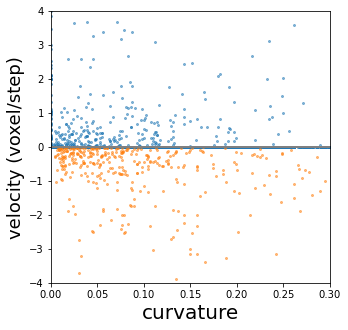

<Figure size 432x288 with 0 Axes>

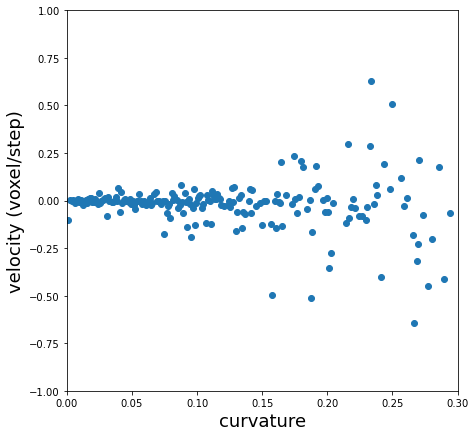

In [398]:

# ignore the sign of curvature for all GBs list
for i in range(len(GB_list_curvature_list)):
    if GB_list_curvature_list[i]<0: 
        GB_list_curvature_list[i] = - GB_list_curvature_list[i]
        GB_list_velocity_list[i] = - GB_list_velocity_list[i]
GB_list_velocity_list = np.array(GB_list_velocity_list)
GB_list_curvature_list = np.array(GB_list_curvature_list)

# figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d.png"
plt.figure()
fig = plt.figure(figsize=(5, 5))
plt.plot([0,0.3],[0,0],'-',color='grey',linewidth=2)
plt.scatter(GB_list_curvature_list[GB_list_velocity_list>=0], GB_list_velocity_list[GB_list_velocity_list>=0],s=4,alpha=0.5)
# plt.scatter(GB_list_curvature_list[GB_list_velocity_list<0], GB_list_velocity_list[GB_list_velocity_list<0],s=4,alpha=0.5,color='C01')
plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
plt.xlabel("curvature", fontsize=20)
plt.ylabel("velocity (voxel/step)", fontsize=18)
plt.xlim([0,0.3])
plt.ylim([-4.0,4.0])
# plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')

# plot velocity VS averaged curvature
bin_interval = 0.001
x_lim = [0.0,0.3]
bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

curvature_bin = np.zeros(bin_number)
velocity_bin = np.zeros(bin_number)
for index in range(len(GB_list_curvature_list)):
    if abs(GB_list_curvature_list[index])>=x_lim[1]: continue
    curvature_bin[int((GB_list_curvature_list[index]-x_lim[0])//bin_interval)] += 1
    velocity_bin[int((GB_list_curvature_list[index]-x_lim[0])//bin_interval)] += GB_list_velocity_list[index]
for i in range(bin_number): 
    if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
# plot
# figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
plt.figure()
fig = plt.figure(figsize=(7, 7))
# plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
plt.xlim([0,0.3])
plt.ylim([-1,1])
plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
plt.xlabel("curvature", fontsize=18)
plt.ylabel("velocity (voxel/step)", fontsize=18)
# plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


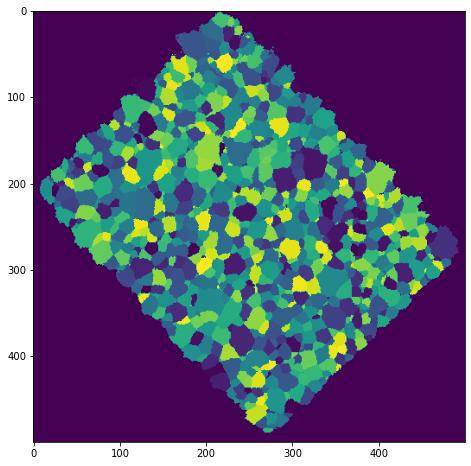

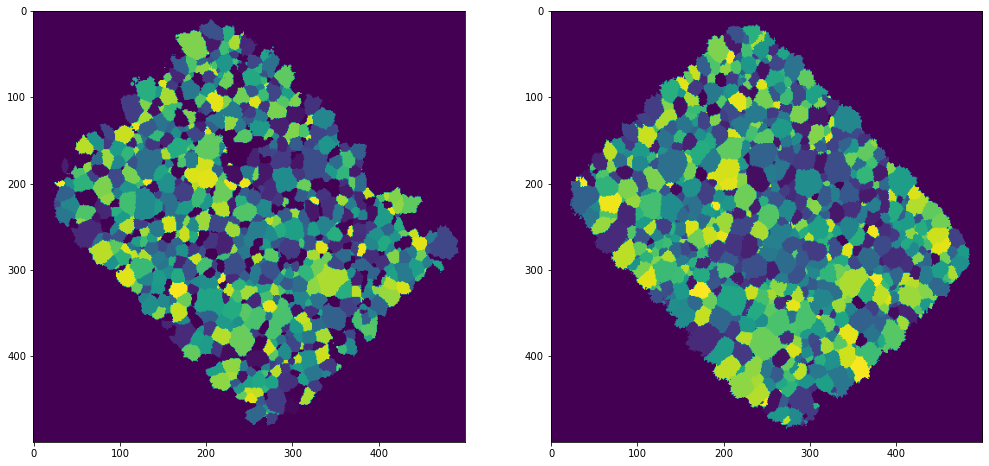

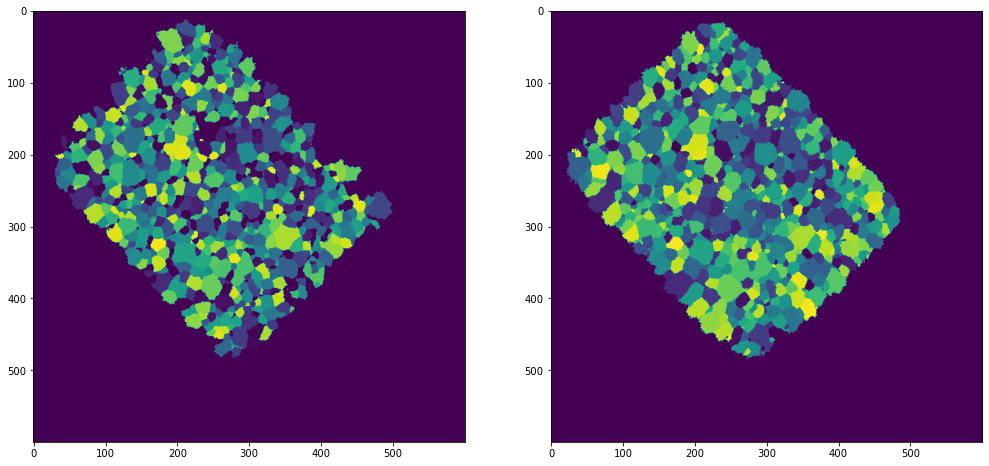

In [399]:
plt.figure(figsize=(17,9))
plt.subplot(121)
plt.imshow(microstructure_t0[10])
plt.figure(figsize=(17,9))
plt.subplot(121)
plt.imshow(microstructure_t0_copy[10])
plt.subplot(122)
plt.imshow(microstructure_t1[10])

# 12,4,6 - (3,6,2)


plt.figure(figsize=(17,9))
plt.subplot(121)
plt.imshow(microstructure_current[10])
plt.subplot(122)
plt.imshow(microstructure_next[10])